# News Mode

1. As of today, the overall sentiment in news organization is negative, with exception of NY Times, which is slightly positive
2. Among all news organizations, BBSWord is most negative
3. New York Times tend to be more positive among the news orgazniations.
4. There are significant number of zero's

BTW:

- I could not find exact match for BBC, so I use BBCWord instead.
- For CBS, I pick CBSNews instead of CBS as CBS in general include not just news, but also entertainments etc.
- There is no twitter handle called FOX, so I pick FoxNewws instead
- For nytimnes, I see the example use 'New York Times' and "NYT' but I stil to nytimes, as it is more consistent this way.


TODO:
- axes.titlesize seems does not work.
- For scatter plot, legend got cut off in exported png file.

## Imports

In [9]:
# Core
from datetime import date
from operator import itemgetter
import json

# Numpy, Pandas and PyPlot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style(
    'darkgrid', 
    {
        'axes.facecolor': '0.9',
        'axes.titlesize': 'x-large',
        'figure.titlesize': 'x-large',
    }
)

# API
import tweepy
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Own
from twitter_config import *

## Gobals & Constants

In [10]:
PAGE_SIZE = 5
PAGES = 2
MEDIA_SOURCES = ['BBCWorld', 'CBSNews', 'CNN', 'FoxNews', 'nytimes']
SCORES = ['compound', 'neg', 'pos', 'neu']

COLORS = {
    'BBCWorld': 'lightskyblue',
    'CBSNews': 'green',
    'CNN': 'lightcoral',
    'FoxNews': 'blue',
    'nytimes': 'gold'
}

TODAY = date.today().strftime('%m/%d/%y')

_AUTH = tweepy.OAuthHandler(TWITTER_CONSUMER_KEY, TWITTER_CONSUMER_SECRET)
_AUTH.set_access_token(TWITTER_ACCESS_TOKEN, TWITTER_TOKEN_SECRET)

TWITTER_API = tweepy.API(_AUTH, parser=tweepy.parsers.JSONParser())
SENTIMENT_ANALYZER = SentimentIntensityAnalyzer()

## Gather Data
Use multil-index to better organize the data

In [11]:
df = pd.DataFrame(
    index=pd.MultiIndex.from_product(
        [MEDIA_SOURCES, list(range(PAGE_SIZE * PAGES))],
        names=['Media Sources', 'Tweets Ago']
    ),
    columns=SCORES
)

for media_source in MEDIA_SOURCES:
    tweets_ago = 0
    for page in range(PAGES):
        for tweet in TWITTER_API.user_timeline(media_source, count=PAGE_SIZE, page=page):
            df.loc[(media_source, tweets_ago), SCORES] = itemgetter(*SCORES)(
                SENTIMENT_ANALYZER.polarity_scores(tweet['text']))
            tweets_ago += 1    
df.head()

compound    neg    pos    neu
Media Sources Tweets Ago                              
BBCWorld      0                 0      0      0      1
              1                 0      0      0      1
              2            0.5719      0  0.346  0.654
              3           -0.5994  0.358      0  0.642
              4                 0      0      0      1

In [12]:
### Export to CSV

In [13]:
df.to_csv('NewsMode.csv')

### Sentiment Scater Plot

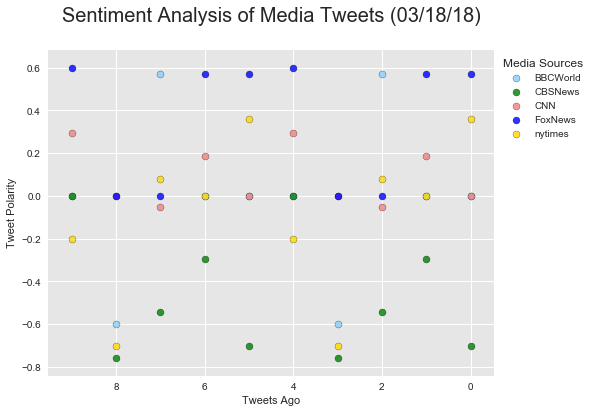

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))

for media_source in MEDIA_SOURCES:
    df_media = df.loc[media_source]
    ax.scatter(
        x=df_media.index,
        y=df_media['compound'],
        c=COLORS[media_source],
        marker='o',
        alpha=0.8,
        edgecolor='black',
        label=media_source
    )

ax.legend(
    title='Media Sources',
    bbox_to_anchor=(1.22, 1)
)

plt.gca().invert_xaxis()
plt.title(f'Sentiment Analysis of Media Tweets ({TODAY})\n', fontsize=20)
plt.xlabel('Tweets Ago')
plt.ylabel('Tweet Polarity')
plt.savefig('NewsMode_scatter.png', bbox_inches='tight')
plt.show()

### Sentiment Averages

In [15]:
df_mean = pd.to_numeric(df['compound']).groupby('Media Sources').mean()
df_mean

Media Sources
BBCWorld   -0.00550
CBSNews    -0.45930
CNN         0.08632
FoxNews     0.34864
nytimes    -0.09284
Name: compound, dtype: float64

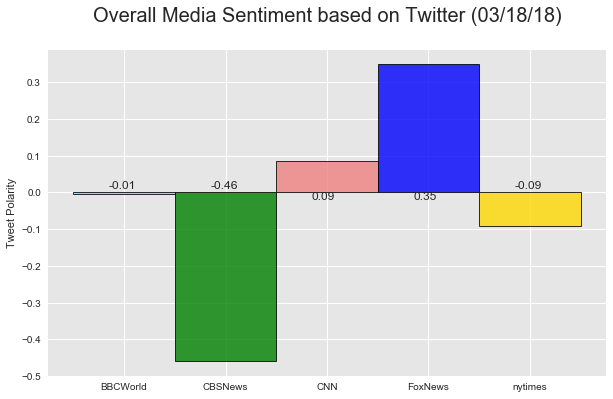

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(
    MEDIA_SOURCES,
    df_mean,
    align='edge',
    width=1,
    edgecolor='black',
    color=[COLORS[m] for m in MEDIA_SOURCES],
    linewidth=1,
    alpha=0.8,
)

plt.title(f'Overall Media Sentiment based on Twitter ({TODAY})\n',
          fontsize=20)
plt.ylabel('Tweet Polarity')
plt.xticks(np.arange(0.5, len(MEDIA_SOURCES)), rotation=0)

# Add labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + 0.35, 
            0.01 if height < 0 else -0.02, 
            '{:.2f}'.format(height))
    
plt.savefig('NewsMode_bar.png')
plt.show()